Assignment 5
Question 1


Preparing the Data

In [ ]:
import zipfile
import os

# Unzip dataset
zip_path = "data.zip"
extract_dir = "data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [ ]:
import shutil
import os

# Defining the paths for chicken and duck images
chicken_path = "data/data/chicken"
duck_path = "data/data/duck"

# Creating directories for train, test, and val splits
os.makedirs("data/chicken-images/data/train", exist_ok=True)
os.makedirs("data/chicken-images/data/test", exist_ok=True)
os.makedirs("data/chicken-images/data/val", exist_ok=True)

os.makedirs("data/duck-images/data/train", exist_ok=True)
os.makedirs("data/duck-images/data/test", exist_ok=True)
os.makedirs("data/duck-images/data/val", exist_ok=True)


for file in os.listdir(chicken_path):
    shutil.move(os.path.join(chicken_path, file), "data/chicken-images/data/train/" + file)

for file in os.listdir(duck_path):
    shutil.move(os.path.join(duck_path, file), "data/duck-images/data/train/" + file)



Normalizing images for fitting in the model

In [31]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder  # Add missing import
import torch.nn as nn

# Define data augmentation for training and test transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the directories
train_dir = "merged_data/train"
test_dir = "merged_data/test"
val_dir = "merged_data/val"

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform_train)
test_dataset = ImageFolder(root=test_dir, transform=transform_test)
val_dataset = ImageFolder(root=val_dir, transform=transform_test)  # Use transform_test here

# Create DataLoader for batching and shuffling data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Get the class labels
class_names = train_dataset.classes
print(f"Class labels: {class_names}")

Class labels: ['chicken', 'duck']


Model Architecture and Modification

In [32]:
# Modify the model to add Dropout layers
model = models.resnet18(pretrained=True)

# Freeze all existing layers
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer with a dropout
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),  # Add dropout to reduce overfitting
    nn.Linear(256, 2)  # 2 classes: duck, chicken
)

# Only train the newly added layers
for param in model.fc.parameters():
    param.requires_grad = True

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Display sample images

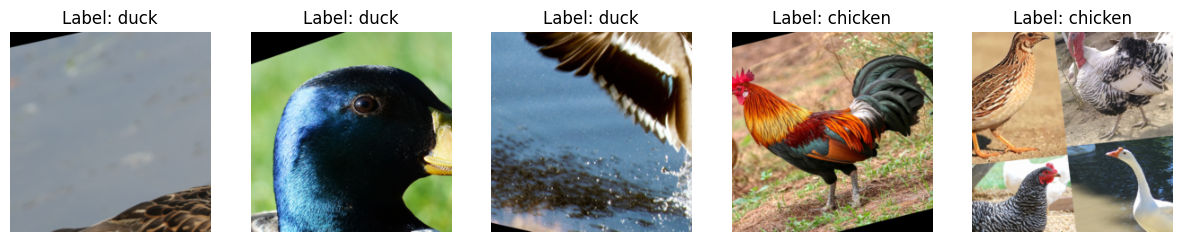

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to display a batch of images
def show_sample_images(dataset, num_images=5):
    # Select a random batch of images
    indices = random.sample(range(len(dataset)), num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()  # Convert tensor to numpy format
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        image = np.clip(image, 0, 1)  # Clip values to valid range
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {class_names[label]}")
        axes[i].axis("off")
    plt.show()

# Display sample images from the training dataset
show_sample_images(train_dataset, num_images=5)


Loading pre-trained model

In [34]:
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers (weights will not be updated during training)
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected (fc) layer to match our problem (2 classes: chicken and duck)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)  # 2 output classes: chicken, duck
)

# Print model architecture
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Fine-tuning

In [35]:
import torch.optim as optim
from tqdm import tqdm

# Move model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 15 # Adjust as needed
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / len(train_loader))

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1: 100%|██████████| 9/9 [00:29<00:00,  3.29s/it, loss=0.582]


Epoch 1, Loss: 0.5820


Epoch 2: 100%|██████████| 9/9 [00:28<00:00,  3.13s/it, loss=0.323]


Epoch 2, Loss: 0.3231


Epoch 3: 100%|██████████| 9/9 [00:27<00:00,  3.06s/it, loss=0.184]


Epoch 3, Loss: 0.1842


Epoch 4: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it, loss=0.152]


Epoch 4, Loss: 0.1524


Epoch 5: 100%|██████████| 9/9 [00:34<00:00,  3.82s/it, loss=0.164]


Epoch 5, Loss: 0.1642


Epoch 6: 100%|██████████| 9/9 [00:41<00:00,  4.56s/it, loss=0.222]


Epoch 6, Loss: 0.2223


Epoch 7: 100%|██████████| 9/9 [00:33<00:00,  3.70s/it, loss=0.131]


Epoch 7, Loss: 0.1315


Epoch 8: 100%|██████████| 9/9 [00:27<00:00,  3.07s/it, loss=0.164]


Epoch 8, Loss: 0.1639


Epoch 9: 100%|██████████| 9/9 [00:28<00:00,  3.14s/it, loss=0.33]


Epoch 9, Loss: 0.3301


Epoch 10: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it, loss=0.0676]


Epoch 10, Loss: 0.0676


Epoch 11: 100%|██████████| 9/9 [00:27<00:00,  3.08s/it, loss=0.188]


Epoch 11, Loss: 0.1876


Epoch 12: 100%|██████████| 9/9 [00:28<00:00,  3.13s/it, loss=0.143]


Epoch 12, Loss: 0.1427


Epoch 13: 100%|██████████| 9/9 [00:28<00:00,  3.13s/it, loss=0.155]


Epoch 13, Loss: 0.1549


Epoch 14: 100%|██████████| 9/9 [00:28<00:00,  3.13s/it, loss=0.125]


Epoch 14, Loss: 0.1250


Epoch 15: 100%|██████████| 9/9 [00:29<00:00,  3.23s/it, loss=0.0864]

Epoch 15, Loss: 0.0864


Classification Report

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Switch model to evaluation mode
model.eval()

# Variables for storing true and predicted labels
y_true = []
y_pred = []

# Collect predictions for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))



Classification Report:
              precision    recall  f1-score   support

     chicken       1.00      0.93      0.97        15
        duck       0.94      1.00      0.97        15

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



Confusion matrix

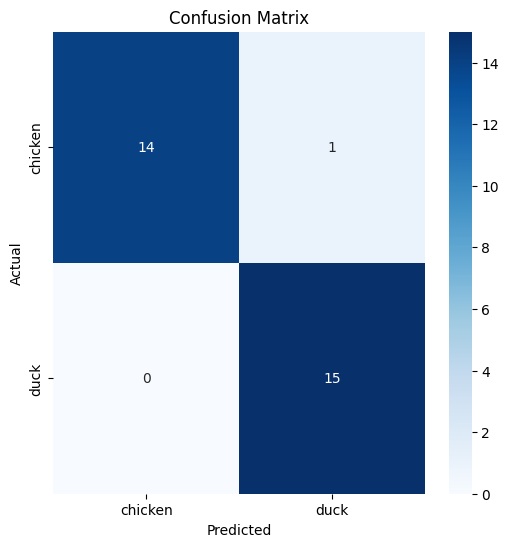

In [37]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Displaying sample predictions

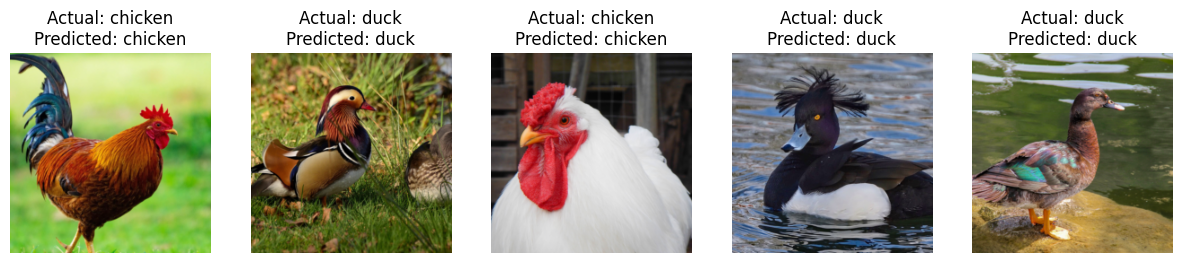

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Collect random samples
sample_images = []
sample_labels = []
sample_preds = []

# Get a few batches from the test loader
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    sample_images.extend(images.cpu())
    sample_labels.extend(labels.cpu().numpy())
    sample_preds.extend(preds.cpu().numpy())

# Select random indices from the collected samples 
num_samples = 5
random_indices = random.sample(range(len(sample_images)), num_samples)

# Prepare the data for visualization (unnormalize)
sample_images = [img.permute(1, 2, 0).cpu().numpy() for img in sample_images]
sample_labels = [train_dataset.classes[label] for label in sample_labels]
sample_preds = [train_dataset.classes[pred] for pred in sample_preds]

# Unnormalize and plot the images with their true and predicted labels
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i, idx in enumerate(random_indices):
    image = sample_images[idx]
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    image = np.clip(image, 0, 1)  # Clip values to valid range
    actual_label = sample_labels[idx]
    predicted_label = sample_preds[idx]

    axes[i].imshow(image)
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    axes[i].axis("off")

plt.show()
